<a href="https://colab.research.google.com/github/dsirtioglu/python/blob/dsirtioglu-RR/Predicting_GDP_Growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project is work-in-progress, aiming to build a GDP growth prediction model.

# Predicting GDP Growth

To-do's (1): 
- Apply/sum any fields where necessary
- Investigate the min-max and frequency of the available dates --done
- Visualize the availability in one chart to have a helicopter view
- Interpolate monthly GDP values in case information loss with quarterly values

In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib
from matplotlib import pyplot as plt

from tabulate import tabulate

!pip install cbsodata
import cbsodata

## GDP

Sourced from https://data.oecd.org/gdp/quarterly-gdp.htm

In [2]:
#Input variable: Economic Output
#Yearly and quarterly percentage changes, all countries

url = 'https://raw.githubusercontent.com/dsirtioglu/python/dsirtioglu-RR/Quarterly%20GDP.csv'

GDP = pd.read_csv(url)
GDP.head(20) 

##Filters to be applied: 

# LOCATION = NLD
# INDICATOR = 'QGDP'
# SUBJECT = 'TOT'
# MEASURE = 'PC_CHGPP'
# FREQUENCY = 'Q' -- For quarterly values
# Flag Codes = E (?)

#Note that 'Value' field indicate the percentage change from the previous quarter in GDP

#Apply relevant filters

GDP_NL = GDP.loc[(GDP['LOCATION'] == 'NLD') & (GDP['INDICATOR'] == 'QGDP') & (GDP['SUBJECT'] == 'TOT') & (GDP['MEASURE'] == 'PC_CHGPP') & (GDP['FREQUENCY'] == 'Q')]

GDP_NL.insert(loc = 0,
              column = 'Period',
              value = GDP_NL.TIME.str[:4] + str('Q') + GDP_NL.TIME.str[-1:])

GDP_NL['Period'] = pd.PeriodIndex(GDP_NL['Period'], freq='Q').to_timestamp()
GDP_NL.sort_values(by=['Period'], inplace=True)
GDP_NL = GDP_NL.set_index('Period', drop = False)

GDP_NL['Flag_negative'] = np.where(GDP_NL.Value <= 0, 1, 0)
GDP_NL.Flag_negative[GDP_NL.index > '1993-01-01'].value_counts()

GDP_NL.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Period,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Flag_negative
Period,,,,,,,,,,
1960-04-01,1960-04-01,NLD,QGDP,TOT,PC_CHGPP,Q,1960-Q2,2.334749,E,0
1960-07-01,1960-07-01,NLD,QGDP,TOT,PC_CHGPP,Q,1960-Q3,-1.710530,E,1
1960-10-01,1960-10-01,NLD,QGDP,TOT,PC_CHGPP,Q,1960-Q4,1.112932,E,0
1961-01-01,1961-01-01,NLD,QGDP,TOT,PC_CHGPP,Q,1961-Q1,0.347489,E,0
1961-04-01,1961-04-01,NLD,QGDP,TOT,PC_CHGPP,Q,1961-Q2,-1.393060,E,1


<function matplotlib.pyplot.show>

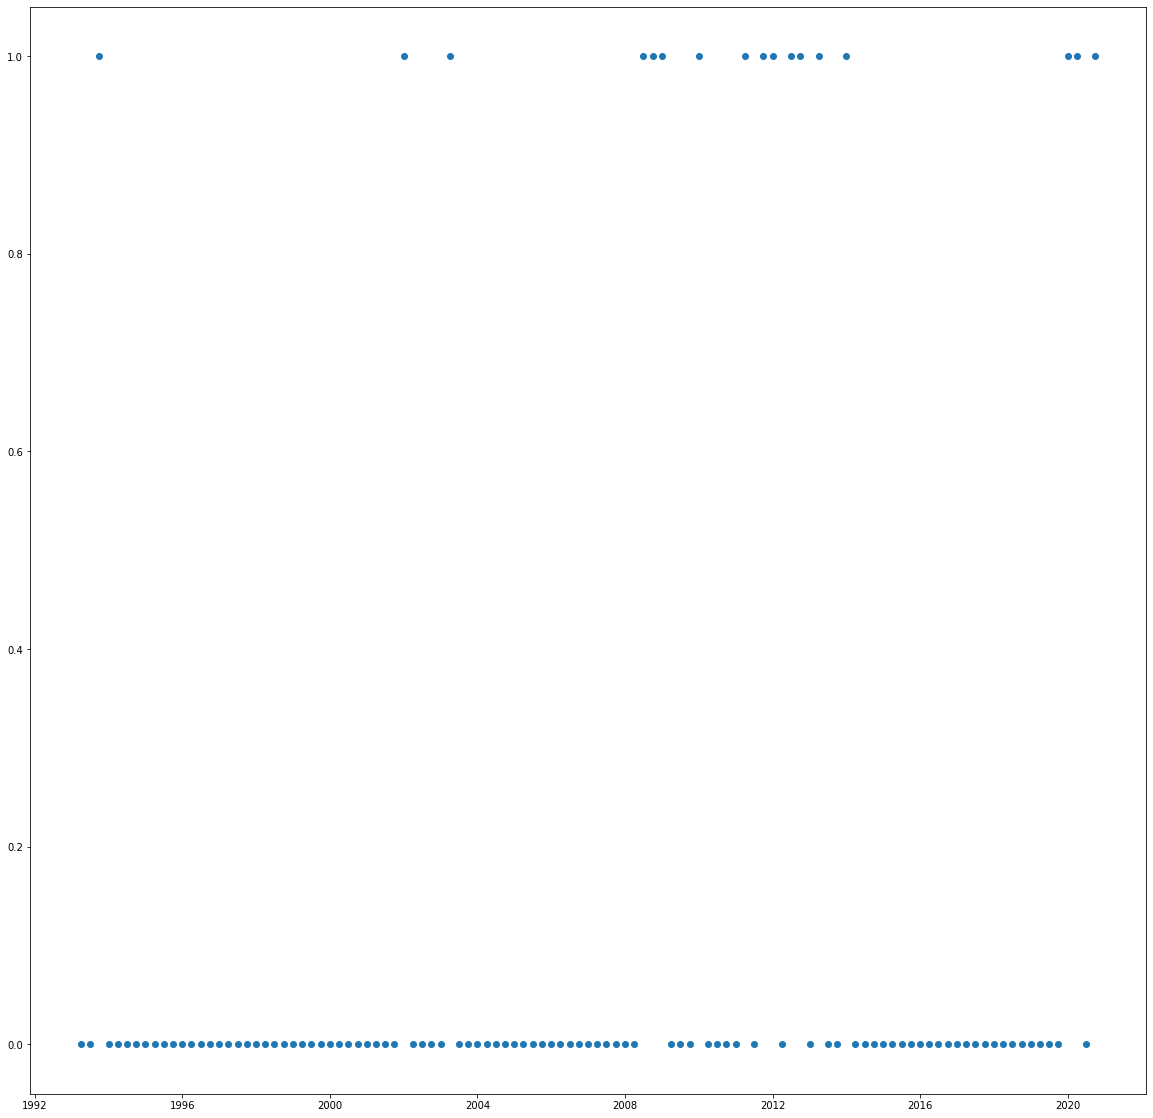

In [3]:
x = GDP_NL.index[GDP_NL.index > '1993-01-01']
y = GDP_NL.Flag_negative[GDP_NL.index > '1993-01-01']

plt.scatter(x, y)
plt.gcf().set_size_inches((20, 20))
plt.show

## AEX Daily Values

In [4]:
#Install yfinance library and download features.xlsx
!pip install yfinance -q

import yfinance as yf

!ls

     |████████████████████████████████| 6.3MB 3.5MB/s 
sample_data


In [5]:
msft = yf.Ticker("^AEX")
AEX = msft.history(period="max") 
AEX

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1992-10-12,126.382904,127.181557,126.056175,126.945595,0,0,0
1992-10-13,126.773155,127.004585,126.491806,126.850296,0,0,0
1992-10-14,126.056175,126.555336,126.001724,126.487274,0,0,0
1992-10-15,126.097015,126.568954,125.688614,125.824753,0,0,0
1992-10-16,126.264915,126.478195,124.858192,125.230293,0,0,0
...,...,...,...,...,...,...,...
2021-06-02,715.929993,719.049988,715.559998,718.929993,64000,0,0
2021-06-03,718.239990,718.380005,712.419983,717.080017,50800,0,0
2021-06-04,717.150024,720.880005,716.090027,720.179993,64000,0,0


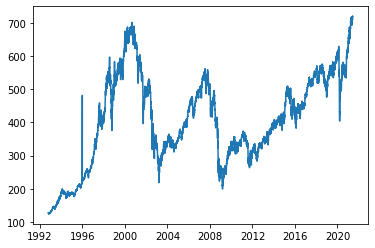

In [6]:
x = AEX.index
y = AEX.Close

plt.plot(x, y)
plt.show()

<function matplotlib.pyplot.show>

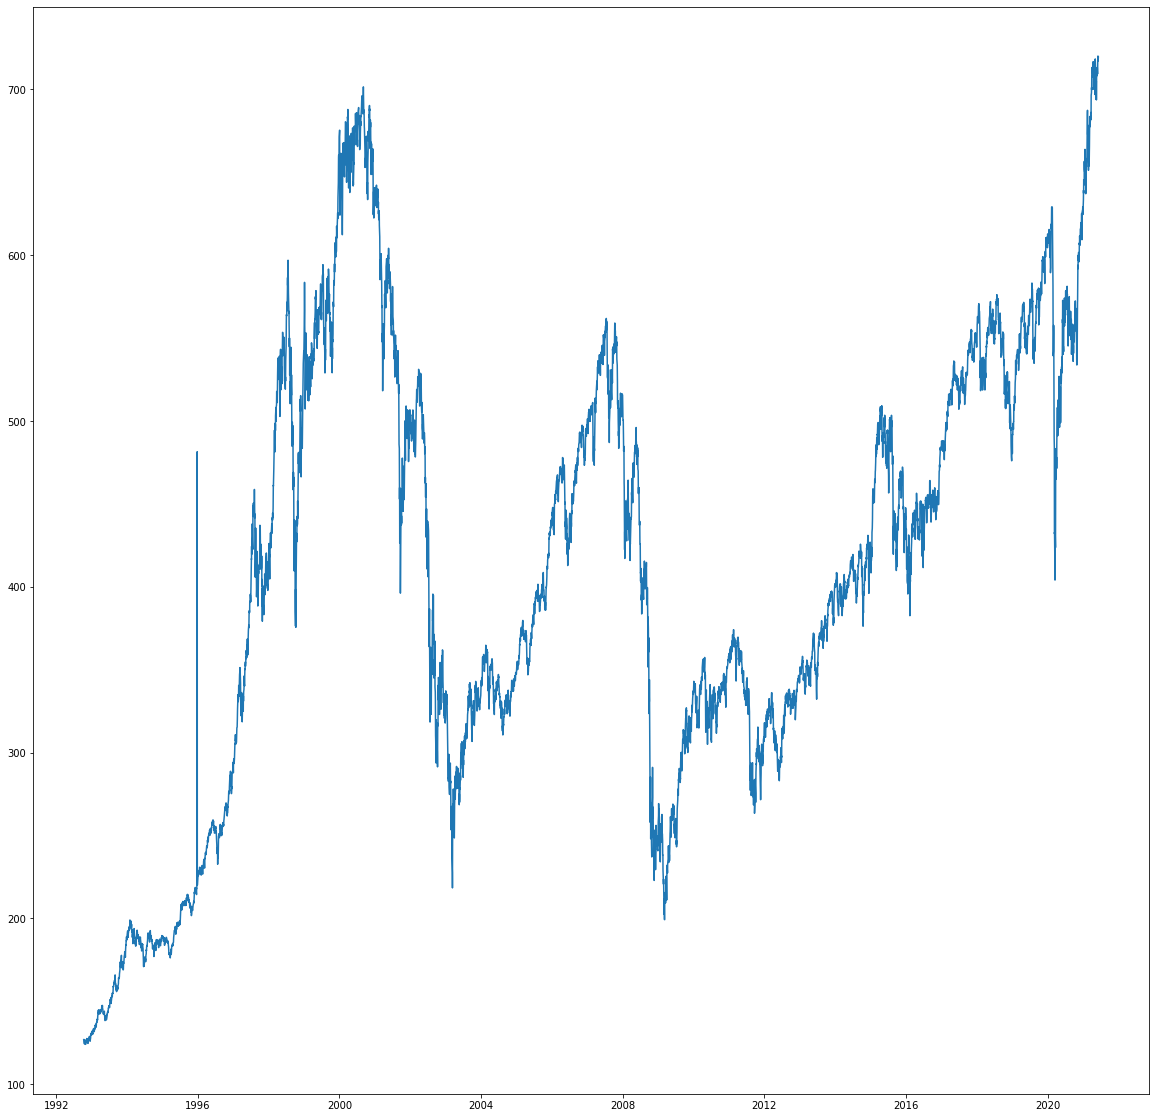

In [7]:
x = AEX.index[AEX.index >= '1960-01-01']
y = AEX.Close[AEX.index >= '1960-01-01']

plt.plot(x, y)
plt.gcf().set_size_inches((20, 20))
plt.show

## Consumer Confidence

In [8]:
Confidence_data = pd.DataFrame(cbsodata.get_data('83693ENG')) ##Consumer confidence, economic climate and willingness to buy
Confidence_data.tail(10)

,ID,Periods,ConsumerConfidence_1,EconomicClimate_2,WillingnessToBuy_3,EconomicSituationLast12Months_4,EconomicSituationNext12Months_5,FinancialSituationLast12Months_6,FinancialSituationNext12Months_7,RightTimeToMakeLargePurchases_8
412,412,2020 August,-29,-58,-9,-73,-44,-3,-2,-23
413,413,2020 September,-28,-58,-9,-75,-40,-5,0,-22
414,414,2020 October,-30,-61,-9,-76,-46,-7,1,-22
415,415,2020 November,-26,-53,-7,-72,-35,-7,3,-18
416,416,2020 December,-20,-40,-6,-70,-9,-7,5,-17
417,417,2021 January,-19,-39,-6,-71,-8,-6,6,-18
418,418,2021 February,-19,-41,-5,-72,-9,-6,8,-17
419,419,2021 March,-18,-39,-4,-77,-1,-6,8,-15
420,420,2021 April,-14,-32,-2,-71,8,-3,9,-11
421,421,2021 May,-9,-24,1,-62,14,0,10,-6


In [9]:
#Fix data issue "2020 Juy" to "2020 July"

Confidence_data["Periods"] = np.where(Confidence_data.Periods == '2020 Juy', '2020 July', Confidence_data.Periods)

#Convert Periods to datetime and define as index
Confidence_data['Period'] = pd.to_datetime(Confidence_data['Periods'])
Confidence_data.sort_values(by=['Periods'])
Confidence_data = Confidence_data.set_index('Period', drop = False)
Confidence_data.head()

,ID,Periods,ConsumerConfidence_1,EconomicClimate_2,WillingnessToBuy_3,EconomicSituationLast12Months_4,EconomicSituationNext12Months_5,FinancialSituationLast12Months_6,FinancialSituationNext12Months_7,RightTimeToMakeLargePurchases_8,Period
Period,,,,,,,,,,,
1986-04-01,0,1986 April,2,6,0,6,5,0,1,-1,1986-04-01
1986-05-01,1,1986 May,8,17,1,17,16,1,5,-2,1986-05-01
1986-06-01,2,1986 June,15,33,3,35,30,2,11,-5,1986-06-01
1986-07-01,3,1986 July,20,45,4,49,41,4,12,-6,1986-07-01
1986-08-01,4,1986 August,21,47,4,53,41,7,14,-7,1986-08-01


## Consumption Expenditure

In [10]:
cbsodata.get_info('82608ENG')
#print(info)

{'Catalog': 'CBS',
 'DefaultPresentation': 'ts=1621251033074&graphtype=Table&r=Periods&k=Topics,ConsumptionByHouseholds',
 'DefaultSelection': "$filter=((ConsumptionByHouseholds eq 'A047812') or (ConsumptionByHouseholds eq 'A047813') or (ConsumptionByHouseholds eq 'A047875') or (ConsumptionByHouseholds eq 'A047825') or (ConsumptionByHouseholds eq 'A048214') or (ConsumptionByHouseholds eq 'A047837')) and ((Periods eq '2019JJ00') or (Periods eq '2020JJ00') or (Periods eq '2020MM03') or (Periods eq '2020KW01') or (Periods eq '2020MM04') or (Periods eq '2020MM05') or (Periods eq '2020MM06') or (Periods eq '2020KW02') or (Periods eq '2020MM07') or (Periods eq '2020MM08') or (Periods eq '2020MM09') or (Periods eq '2020KW03') or (Periods eq '2020MM10') or (Periods eq '2020MM11') or (Periods eq '2020MM12') or (Periods eq '2020KW04') or (Periods eq '2021MM01') or (Periods eq '2021MM02') or (Periods eq '2021MM03') or (Periods eq '2021KW01'))&$select=ConsumptionByHouseholds, Periods, VolumeChange

In [11]:
Consumption = pd.DataFrame(cbsodata.get_data('82608ENG')) #VolumeChangesShoppingdayAdjusted_3
Consumption.tail()
## Filter needed

,ID,ConsumptionByHouseholds,Periods,Indices_1,VolumeChanges_2,VolumeChangesShoppingdayAdjusted_3,Indices_4,ValueChanges_5,PriceChanges_6
5049,5049,Consumption of services by households,2020 4th quarter,92.8,-14.3,-14.3,102.6,-12.3,2.4
5050,5050,Consumption of services by households,2021 January,88.5,-16.8,-16.8,98.8,-14.5,2.8
5051,5051,Consumption of services by households,2021 February,89.0,-18.2,-16.9,99.5,-15.5,3.3
5052,5052,Consumption of services by households,2021 March,90.9,-3.0,-3.0,101.8,-0.5,2.5
5053,5053,Consumption of services by households,2021 1st quarter,89.5,-13.1,-12.7,100.0,-10.6,2.9


In [12]:
#Look for unique categories in ConsumptionByHouseholds
Consumption.ConsumptionByHouseholds.unique()

array(['Domestic consumption by households',
       'Consumption of goods by households',
       'Foodproducts, beverages and tabacco', 'Durable consumer goods',
       'Textiles and clothing', 'Leather goods and footwear',
       'Home furnishing and home decoration', 'Electrical equipment',
       'Vehicles', 'Other durable consumer goods n.e.c.', 'Other goods',
       'Electricity, gas, water and motor fuels',
       'Personal care and other goods',
       'Consumption of services by households'], dtype=object)

In [13]:
#Retrieve only ConsumptionByHouseholds = Domestic consumption by households 
Consumption = Consumption.loc[Consumption['ConsumptionByHouseholds'] == 'Domestic consumption by households']

#Filter out quarterly and yearly values
Consumption_monthly = Consumption.loc[(Consumption['Periods'].str[-7:] != 'quarter') & (Consumption['Periods'].str[4:5] == ' ')]

#Convert Periods to datetime and define as index
Consumption_monthly['Period'] = pd.to_datetime(Consumption_monthly['Periods'])
Consumption_monthly.sort_values(by=['Periods'], inplace=True)
Consumption_monthly = Consumption_monthly.set_index('Period', drop = False)

Consumption_monthly.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,ID,ConsumptionByHouseholds,Periods,Indices_1,VolumeChanges_2,VolumeChangesShoppingdayAdjusted_3,Indices_4,ValueChanges_5,PriceChanges_6,Period
Period,,,,,,,,,,
2020-10-01,353,Domestic consumption by households,2020 October,101.4,-5.3,-6.0,110.8,-4.1,1.3,2020-10-01
2020-09-01,351,Domestic consumption by households,2020 September,103.9,-2.6,-3.7,111.6,-1.5,1.0,2020-09-01
2021-02-01,358,Domestic consumption by households,2021 February,91.2,-14.0,-11.6,100.8,-11.8,2.5,2021-02-01
2021-01-01,357,Domestic consumption by households,2021 January,94.2,-13.7,-13.1,103.3,-12.0,2.0,2021-01-01
2021-03-01,359,Domestic consumption by households,2021 March,100.0,0.9,-0.4,110.9,3.1,2.2,2021-03-01


## Inflation

In [14]:
CPI = pd.DataFrame(cbsodata.get_data('83131ENG'))
CPI.head()

,ID,ExpenditureCategories,Periods,CPI_1,DerivedCPI_2,MonthOnMonthChangeCPI_3,MonthOnMonthChangeDerivedCPI_4,YearOnYearChangeCPI_5,YearOnYearChangeDerivedCPI_6,WeightingCoefficient_7
0,0,000000 All items,1996 January,68.03,72.28,NaN,NaN,NaN,NaN,100000
1,1,000000 All items,1996 February,68.29,72.55,0.4,0.4,NaN,NaN,100000
2,2,000000 All items,1996 March,68.92,73.22,0.9,0.9,NaN,NaN,100000
3,3,000000 All items,1996 April,69.13,73.44,0.3,0.3,NaN,NaN,100000
4,4,000000 All items,1996 May,68.96,73.26,-0.2,-0.2,NaN,NaN,100000


In [15]:
CPI.Periods.unique()
CPI['Period'] = pd.to_datetime(CPI['Periods'])
CPI.sort_values(by=['Periods'], inplace=True)
CPI = CPI.set_index('Period', drop = False)
CPI.head()

,ID,ExpenditureCategories,Periods,CPI_1,DerivedCPI_2,MonthOnMonthChangeCPI_3,MonthOnMonthChangeDerivedCPI_4,YearOnYearChangeCPI_5,YearOnYearChangeDerivedCPI_6,WeightingCoefficient_7,Period
Period,,,,,,,,,,,
1996-01-01,129702,SA22 Seasonal food,1996,67.74,67.74,NaN,NaN,NaN,NaN,2723,1996-01-01
1996-01-01,80862,"091000 Audio-vis., photogr. equipment",1996,386.59,398.11,NaN,NaN,NaN,NaN,2113,1996-01-01
1996-01-01,33342,032120 Footwear for women,1996,81.88,84.67,NaN,NaN,NaN,NaN,493,1996-01-01
1996-01-01,81192,091100 Audio-visual equipment…,1996,424.25,436.88,NaN,NaN,NaN,NaN,750,1996-01-01
1996-01-01,5292,011240 Poultry,1996,86.02,86.02,NaN,NaN,NaN,NaN,327,1996-01-01


## Housing Stock

In [16]:
Housing_Stock = pd.DataFrame(cbsodata.get_data('81955ENG')) ##Takes 6 mins to run

Housing_Stock = Housing_Stock[(Housing_Stock.Purpose == 'Housing function') & (Housing_Stock.Regions == 'The Netherlands')]

#Purpose == 'Housing function' /or/ 'Housing and non-residential function'
#Regions == 'The Netherlands'
#Housing_Stock.Regions.unique()
Housing_Stock.tail()

,ID,Purpose,Regions,Periods,InitialStock_1,NewConstruction_2,OtherAdditions_3,Demolition_4,OtherWithdrawals_5,Corrections_6,StockBalance_7,FinalStock_8
78205,78205,Housing function,The Netherlands,2021 January,7966331.0,5409.0,2383.0,1085.0,742.0,7.0,5972.0,7972303.0
78206,78206,Housing function,The Netherlands,2021 February,7972303.0,4731.0,2343.0,896.0,701.0,130.0,5607.0,7977910.0
78207,78207,Housing function,The Netherlands,2021 March,7977910.0,8977.0,2700.0,897.0,1059.0,189.0,9910.0,7987820.0
78208,78208,Housing function,The Netherlands,2021 1st quarter,7966331.0,19117.0,7426.0,2878.0,2502.0,326.0,21489.0,7987820.0
78209,78209,Housing function,The Netherlands,2021 April,7987820.0,5071.0,1739.0,912.0,630.0,51.0,5319.0,7993139.0


In [17]:
#Filter out quarterly and yearly values
Housing_Stock = Housing_Stock.loc[(Housing_Stock['Periods'].str[-7:] != 'quarter') & (Housing_Stock['Periods'].str[4:5] == ' ')]

#Convert Periods to datetime and define as index
Housing_Stock['Period'] = pd.to_datetime(Housing_Stock['Periods'])
Housing_Stock.sort_values(by=['Periods'], inplace=True)
Housing_Stock = Housing_Stock.set_index('Period', drop = False)

Housing_Stock.tail()

,ID,Purpose,Regions,Periods,InitialStock_1,NewConstruction_2,OtherAdditions_3,Demolition_4,OtherWithdrawals_5,Corrections_6,StockBalance_7,FinalStock_8,Period
Period,,,,,,,,,,,,,
2020-09-01,78198,Housing function,The Netherlands,2020 September,7939261.0,5143.0,1710.0,709.0,559.0,-77.0,5508.0,7944769.0,2020-09-01
2021-04-01,78209,Housing function,The Netherlands,2021 April,7987820.0,5071.0,1739.0,912.0,630.0,51.0,5319.0,7993139.0,2021-04-01
2021-02-01,78206,Housing function,The Netherlands,2021 February,7972303.0,4731.0,2343.0,896.0,701.0,130.0,5607.0,7977910.0,2021-02-01
2021-01-01,78205,Housing function,The Netherlands,2021 January,7966331.0,5409.0,2383.0,1085.0,742.0,7.0,5972.0,7972303.0,2021-01-01
2021-03-01,78207,Housing function,The Netherlands,2021 March,7977910.0,8977.0,2700.0,897.0,1059.0,189.0,9910.0,7987820.0,2021-03-01


## Unemployment

In [18]:
Unemployment = pd.DataFrame(cbsodata.get_data('80479eng'))
Unemployment.tail()

,ID,Sex,Age,Periods,NotSeasonallyAdjusted_1,SeasonallyAdjusted_2,NotSeasonallyAdjusted_3,SeasonallyAdjusted_4,NotSeasonallyAdjusted_5,SeasonallyAdjusted_6,NotSeasonallyAdjusted_7,SeasonallyAdjustedUnemploymentRate_8,NotSeasonallyAdjusted_9,SeasonallyAdjusted_10,NotSeasonallyAdjusted_11,SeasonallyAdjusted_12,NotSeasonallyAdjusted_13,SeasonallyAdjusted_14
3511,3511,Women,45 until 65 years,2019,1631.0,NaN,1568.0,NaN,63.0,NaN,3.8,NaN,766.0,NaN,68.0,NaN,65.4,NaN
3512,3512,Women,45 until 65 years,2020 January,1636.0,1638.0,1582.0,1586.0,54.0,51.0,3.3,3.1,762.0,761.0,68.2,68.3,66.0,66.1
3513,3513,Women,45 until 65 years,2020 February,1642.0,1640.0,1587.0,1589.0,55.0,51.0,3.3,3.1,756.0,758.0,68.5,68.4,66.2,66.3
3514,3514,Women,45 until 65 years,2020 March,1645.0,1643.0,1588.0,1590.0,57.0,53.0,3.4,3.2,752.0,754.0,68.6,68.5,66.3,66.3
3515,3515,Women,45 until 65 years,2020 1st quarter,1641.0,1640.0,1586.0,1588.0,55.0,52.0,3.4,3.2,757.0,758.0,68.4,68.4,66.1,66.2


In [19]:
#Filter out quarterly and yearly values
Unemployment = Unemployment.loc[(Unemployment['Periods'].str[-7:] != 'quarter') & (Unemployment['Periods'].str[4:5] == ' ')]

#Convert Periods to datetime and define as index
Unemployment['Period'] = pd.to_datetime(Unemployment['Periods'])
Unemployment.sort_values(by=['Periods'], inplace=True)

Unemployment.tail()

,ID,Sex,Age,Periods,NotSeasonallyAdjusted_1,SeasonallyAdjusted_2,NotSeasonallyAdjusted_3,SeasonallyAdjusted_4,NotSeasonallyAdjusted_5,SeasonallyAdjusted_6,NotSeasonallyAdjusted_7,SeasonallyAdjustedUnemploymentRate_8,NotSeasonallyAdjusted_9,SeasonallyAdjusted_10,NotSeasonallyAdjusted_11,SeasonallyAdjusted_12,NotSeasonallyAdjusted_13,SeasonallyAdjusted_14,Period
877,877,Total sex,25 until 45 years,2020 March,3691.0,3685.0,3550.0,3556.0,141.0,130.0,3.8,3.5,558.0,564.0,86.9,86.7,83.5,83.7,2020-03-01
584,584,Total sex,15 until 25 years,2020 March,854.0,889.0,767.0,803.0,86.0,86.0,10.1,9.7,1271.0,1235.0,40.2,41.8,36.1,37.8,2020-03-01
291,291,Total sex,15 until 65 years,2020 March,8221.0,8247.0,7887.0,7933.0,334.0,314.0,4.1,3.8,2935.0,2910.0,73.7,73.9,70.7,71.1,2020-03-01
3221,3221,Women,25 until 45 years,2020 March,1755.0,1751.0,1686.0,1686.0,70.0,65.0,4.0,3.7,361.0,365.0,83.0,82.7,79.7,79.7,2020-03-01
3514,3514,Women,45 until 65 years,2020 March,1645.0,1643.0,1588.0,1590.0,57.0,53.0,3.4,3.2,752.0,754.0,68.6,68.5,66.3,66.3,2020-03-01


In [20]:
cols = ['Period', 'Sex', 'Age', 'SeasonallyAdjustedUnemploymentRate_8']
Unemployment_scoped = Unemployment[cols]
Unemployment_scoped = Unemployment_scoped[Unemployment_scoped.Sex == 'Total sex']
Unemployment_scoped = Unemployment_scoped.groupby(['Period','Sex']).sum().reset_index()

Unemployment_scoped = Unemployment_scoped.set_index('Period', drop = False)

Unemployment_scoped.tail(10)

,Period,Sex,SeasonallyAdjustedUnemploymentRate_8
Period,,,
2019-06-01,2019-06-01,Total sex,20.8
2019-07-01,2019-07-01,Total sex,21.0
2019-08-01,2019-08-01,Total sex,22.1
2019-09-01,2019-09-01,Total sex,22.2
2019-10-01,2019-10-01,Total sex,21.9
2019-11-01,2019-11-01,Total sex,21.8
2019-12-01,2019-12-01,Total sex,20.7
2020-01-01,2020-01-01,Total sex,19.1
2020-02-01,2020-02-01,Total sex,18.9


## NL Bond Yields

Sourced from: https://www.investing.com/rates-bonds/netherlands-10-year-bond-yield-historical-data

In [21]:
url = 'https://raw.githubusercontent.com/dsirtioglu/python/dsirtioglu-RR/Netherlands%2010-Year%20Bond%20Yield%20Historical%20Data.csv'

Bond_Yield = pd.read_csv(url)
Bond_Yield.head()

,Date,Price,Open,High,Low,Change %
0,"May 09, 2021",0.037,-0.045,0.062,-0.068,-157.81%
1,"May 02, 2021",-0.064,-0.055,-0.015,-0.106,20.75%
2,"Apr 25, 2021",-0.053,-0.191,-0.047,-0.211,-73.89%
3,"Apr 18, 2021",-0.203,-0.209,-0.154,-0.228,-1.93%
4,"Apr 11, 2021",-0.207,-0.244,-0.192,-0.267,-13.39%


In [22]:
Bond_Yield['Period'] = pd.to_datetime(Bond_Yield['Date'])
Bond_Yield.sort_values(by=['Period'], inplace=True)

Bond_Yield = Bond_Yield.set_index('Period', drop = False)

Bond_Yield.head()

,Date,Price,Open,High,Low,Change %,Period
Period,,,,,,,
1993-01-24,"Jan 24, 1993",7.047,7.047,7.047,7.047,-0.01%,1993-01-24
1993-01-31,"Jan 31, 1993",7.015,7.015,7.015,7.015,-0.45%,1993-01-31
1993-02-07,"Feb 07, 1993",6.903,6.903,6.903,6.903,-1.60%,1993-02-07
1993-02-14,"Feb 14, 1993",6.753,6.753,6.753,6.753,-2.17%,1993-02-14
1993-02-21,"Feb 21, 1993",6.572,6.572,6.572,6.572,-2.68%,1993-02-21


## Discover the data

In [23]:
#Inventory of tables:

#GDP
gdp_min_date = GDP_NL.index.min() ##row counts, min and max dates. Also add frequency
gdp_max_date = GDP_NL.index.max()
gdp_row_count = len(GDP_NL.index)
gdp_freq = 'Quarterly'

#AEX
aex_min_date = AEX.index.min() ##row counts, min and max dates. Frequency: Daily
aex_max_date = AEX.index.max()
aex_row_count = len(AEX.index)
aex_freq = 'Daily'

#Confidence_data
conf_min_date = Confidence_data.index.min() ##row counts, min and max dates. Frequency: Monthly
conf_max_date = Confidence_data.index.max()
conf_row_count = len(Confidence_data.index)
conf_freq = 'Monthly'

#Consumption Expenditure
cons_min_date = Consumption_monthly.index.min() ##row counts, min and max dates. Frequency: Monthly
cons_max_date = Consumption_monthly.index.max()
cons_row_count = len(Consumption_monthly.index)
cons_freq = 'Monthly'

#Inflation
cpi_min_date = CPI.index.min() ##row counts, min and max dates. Frequency: Monthly
cpi_max_date = CPI.index.max()
cpi_row_count = len(CPI.index)
cpi_freq = 'Monthly'

#Housing stock
housing_min_date = Housing_Stock.index.min() ##row counts, min and max dates. Frequency: Monthly
housing_max_date = Housing_Stock.index.max()
housing_row_count = len(Housing_Stock.index)
housing_freq = 'Monthly'

#Unemployment
ue_min_date = Unemployment_scoped.index.min() ##row counts, min and max dates. Frequency: Monthly
ue_max_date = Unemployment_scoped.index.max()
ue_row_count = len(Unemployment_scoped.index)
ue_freq = 'Monthly'

#NL Bond Yields
nl_bonds_min_date = Bond_Yield.index.min() ##row counts, min and max dates. Frequency: Weekly
nl_bonds_max_date = Bond_Yield.index.max()
nl_bonds_row_count = len(Bond_Yield.index)
nl_bonds_freq = 'Weekly'


print(tabulate([['GDP', gdp_min_date, gdp_max_date, gdp_row_count, gdp_freq],
                ['AEX', aex_min_date, aex_max_date, aex_row_count, aex_freq],
                ['Confidence', conf_min_date, conf_max_date, conf_row_count, conf_freq],
                ['Consumption', cons_min_date, cons_max_date, cons_row_count, cons_freq],
                ['Inflation', cpi_min_date, cpi_max_date, cpi_row_count, cpi_freq],
                ['Housing stock', housing_min_date, housing_max_date, housing_row_count, housing_freq],
                ['Unemployment', ue_min_date, ue_max_date, ue_row_count, ue_freq],
                ['NL Bond Yields', nl_bonds_min_date, nl_bonds_max_date, nl_bonds_row_count, nl_bonds_freq]],
               headers=['Dataset', 'First Date Available', 'Last Date Available', 'Row Count', 'Frequency']))

#Look for any NaNs
#dataset_for_label.isnull().values.any()


Dataset         First Date Available    Last Date Available      Row Count  Frequency
--------------  ----------------------  ---------------------  -----------  -----------
GDP             1960-04-01 00:00:00     2020-10-01 00:00:00            243  Quarterly
AEX             1992-10-12 00:00:00     2021-06-08 00:00:00           7307  Daily
Confidence      1986-04-01 00:00:00     2021-05-01 00:00:00            422  Monthly
Consumption     2000-01-01 00:00:00     2021-03-01 00:00:00            255  Monthly
Inflation       1996-01-01 00:00:00     2021-05-01 00:00:00         133980  Monthly
Housing stock   2012-01-01 00:00:00     2021-04-01 00:00:00            112  Monthly
Unemployment    2003-01-01 00:00:00     2020-03-01 00:00:00            207  Monthly
NL Bond Yields  1993-01-24 00:00:00     2021-05-09 00:00:00           1477  Weekly
